# Tokyo Weather Forecast Using LSTM

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## 1. Data Preparation

In [3]:
from google.colab import files
import io

uploaded = files.upload()
df = pd.read_csv(io.BytesIO(uploaded['tokyo_weather_19900101_to_20241130.csv']))

Saving tokyo_weather_19900101_to_20241130.csv to tokyo_weather_19900101_to_20241130.csv


In [4]:
df = pd.read_csv('/content/tokyo_weather_19900101_to_20241130.csv')

In [5]:
df.columns

Index(['name', 'datetime', 'tempmax', 'tempmin', 'temp', 'feelslikemax',
       'feelslikemin', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob',
       'precipcover', 'preciptype', 'snow', 'snowdepth', 'windgust',
       'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility',
       'solarradiation', 'solarenergy', 'uvindex', 'severerisk', 'sunrise',
       'sunset', 'moonphase', 'conditions', 'description', 'icon', 'stations'],
      dtype='object')

In [6]:
df_update = df[['datetime', 'temp', 'dew', 'humidity', 'precip', 'snow', 'windspeed', 'sealevelpressure', 'cloudcover', 'solarradiation', 'solarenergy', 'uvindex']].copy()

In [7]:
df_update = df_update.rename(columns={'datetime': 'date', 'temp': 'temperature', 'precip': 'precipitation'})
df_update['date'] = pd.to_datetime(df_update['date'])

In [8]:
df_update.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12753 entries, 0 to 12752
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              12753 non-null  datetime64[ns]
 1   temperature       12753 non-null  float64       
 2   dew               12753 non-null  float64       
 3   humidity          12753 non-null  float64       
 4   precipitation     12753 non-null  float64       
 5   snow              3708 non-null   float64       
 6   windspeed         12753 non-null  float64       
 7   sealevelpressure  12753 non-null  float64       
 8   cloudcover        12753 non-null  float64       
 9   solarradiation    5448 non-null   float64       
 10  solarenergy       5448 non-null   float64       
 11  uvindex           5448 non-null   float64       
dtypes: datetime64[ns](1), float64(11)
memory usage: 1.2 MB


In [9]:
df_update.isna().sum()

,0
date,0
temperature,0
dew,0
humidity,0
precipitation,0
snow,9045
windspeed,0
sealevelpressure,0
cloudcover,0
solarradiation,7305


In [10]:
df_update.duplicated().sum()

0

In [11]:
# Set plot style
plt.style.use('ggplot')
g = sns.PairGrid(df_update[['temperature', 'dew', 'humidity', 'precipitation', 'snow', 'windspeed', 'sealevelpressure', 'cloudcover', 'solarradiation', 'solarenergy', 'uvindex']])
g.map(sns.scatterplot)
plt.show()

`temperature`, `dew`, `humidity`, `snow` show observable correlation.

Null in `snow` is filled with `0`.  

In [12]:
df_update['snow'] = df_update['snow'].fillna(0)

`solarradiation`, `solarenergy` and `uvindex` are removed since there are missing data from year 1990 to 2009.

In [ ]:
df_update = df.dropna()

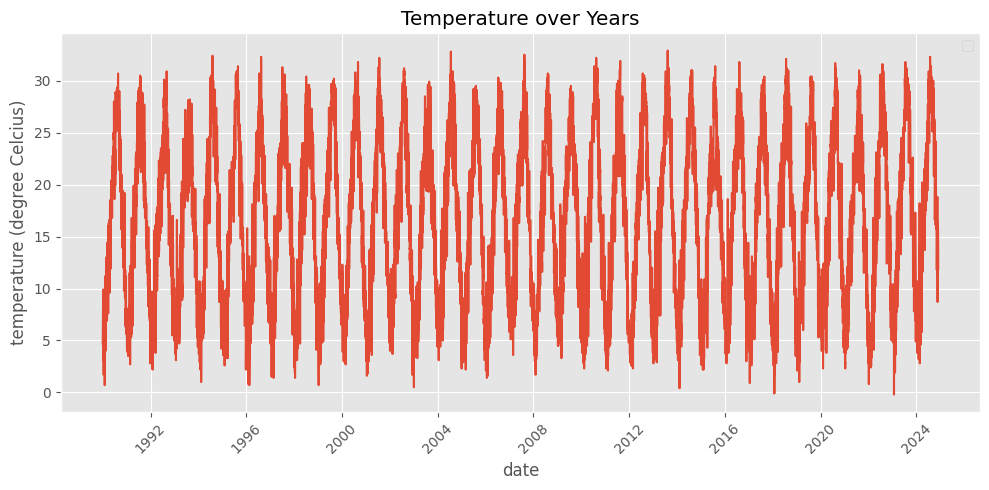

In [ ]:
plt.style.use('ggplot')
plt.figure(figsize=(10, 5))
plt.plot(df_update["date"], df_update["temperature"])
plt.xlabel("date")
plt.ylabel("temperature (degree Celcius)")
plt.title("Temperature over Years")
plt.legend()
plt.xticks(rotation=45)  # Rotate date labels for better visibility
plt.tight_layout()

## 3. Temperature Forecast using LSTM

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [ ]:
df_temp = df_update[['date', 'temperature', 'dew', 'humidity', 'precipitation', 'snow', 'windspeed', 'sealevelpressure', 'cloudcover']].copy()

In [ ]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12753 entries, 0 to 12752
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              12753 non-null  datetime64[ns]
 1   temperature       12753 non-null  float64       
 2   dew               12753 non-null  float64       
 3   humidity          12753 non-null  float64       
 4   precipitation     12753 non-null  float64       
 5   snow              12753 non-null  float64       
 6   windspeed         12753 non-null  float64       
 7   sealevelpressure  12753 non-null  float64       
 8   cloudcover        12753 non-null  float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 896.8 KB


In [ ]:
# Define LSTM Model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
# Define Custom Dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, input_data, target, seq_length):
        self.input_data = input_data
        self.target = target
        self.seq_length = seq_length

    def __len__(self):
        # Length should ensure no out-of-bounds access
        return len(self.input_data) - self.seq_length

    def __getitem__(self, idx):
        if idx + self.seq_length > len(self.input_data):
            raise IndexError("Index exceeds sequence bounds.")
        x = self.input_data[idx:idx + self.seq_length]
        y = self.target[idx + self.seq_length]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


In [ ]:
# Data Preprocessing
input_data = df_temp.drop(['date'], axis=1).values
target = df_temp['temperature'].values

seq_length = 20
batch_size = 4096

# Normalize Input Data
input_scaler = MinMaxScaler(feature_range=(0, 1))
scaled_input_data =  input_scaler.fit_transform(input_data)

# Reshape target into a 2D array with one column for scaling
target = target.reshape(-1, 1)

target_scaler = MinMaxScaler(feature_range=(0, 1))
scaled_target = target_scaler.fit_transform(target)

# Split Data into Train/Test
train_size = int(len(input_data) * 0.8)

train_input = scaled_input_data[:train_size]
train_target = scaled_target[:train_size]
test_input = scaled_input_data[train_size - seq_length:]  # Include last sequence overlap
test_target = scaled_target[train_size - seq_length:]

# Create Datasets and Loaders
train_dataset = TimeSeriesDataset(train_input, train_target, seq_length)
test_dataset = TimeSeriesDataset(test_input, test_target, seq_length)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False) # shuffle=True
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Model Hyperparameters
input_size = train_input.shape[1]
hidden_size = 512
num_layers = 2
output_size = 1
learning_rate = 0.001
num_epochs = 300

# Initialize Model, Loss Function, and Optimizer
model = LSTM(input_size, hidden_size, num_layers, output_size).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-4)

# Training and Evaluation
train_losses = []
test_losses = []

In [ ]:
for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0

    for i, (x_batch, y_batch) in enumerate(train_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        y_pred = model(x_batch)
        loss = loss_fn(y_pred, y_batch)

        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    # Record Train Loss for Epoch
    train_loss = running_train_loss / len(train_loader)
    train_losses.append(train_loss)

    # Evaluate on Test Set
    model.eval()
    running_test_loss = 0.0

    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            y_pred = model(x_batch)
            loss = loss_fn(y_pred, y_batch)

            running_test_loss += loss.item()

    # Record Test Loss for Epoch
    test_loss = running_test_loss / len(test_loader)
    test_losses.append(test_loss)

    if (epoch + 1) % 50 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.3f}, Test Loss: {test_loss:.3f}')

print('Finished Training')

Epoch 50/300, Train Loss: 0.005, Test Loss: 0.006
Epoch 100/300, Train Loss: 0.005, Test Loss: 0.005
Epoch 150/300, Train Loss: 0.004, Test Loss: 0.004
Epoch 200/300, Train Loss: 0.003, Test Loss: 0.003
Epoch 250/300, Train Loss: 0.003, Test Loss: 0.003
Epoch 300/300, Train Loss: 0.003, Test Loss: 0.003
Finished Training


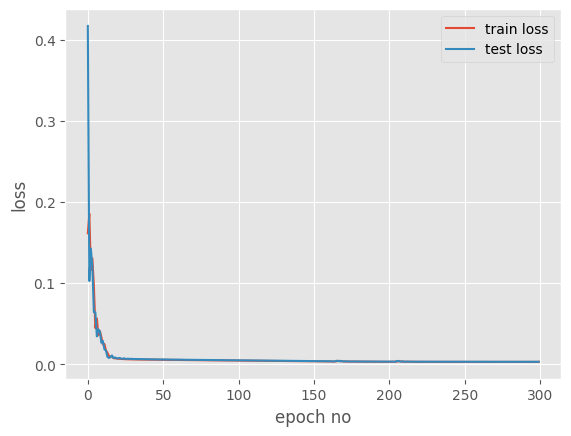

In [ ]:
# Plot the train loss and test loss per iteration
plt.style.use('ggplot')
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.xlabel('epoch no')
plt.ylabel('loss')
plt.legend()
plt.show()

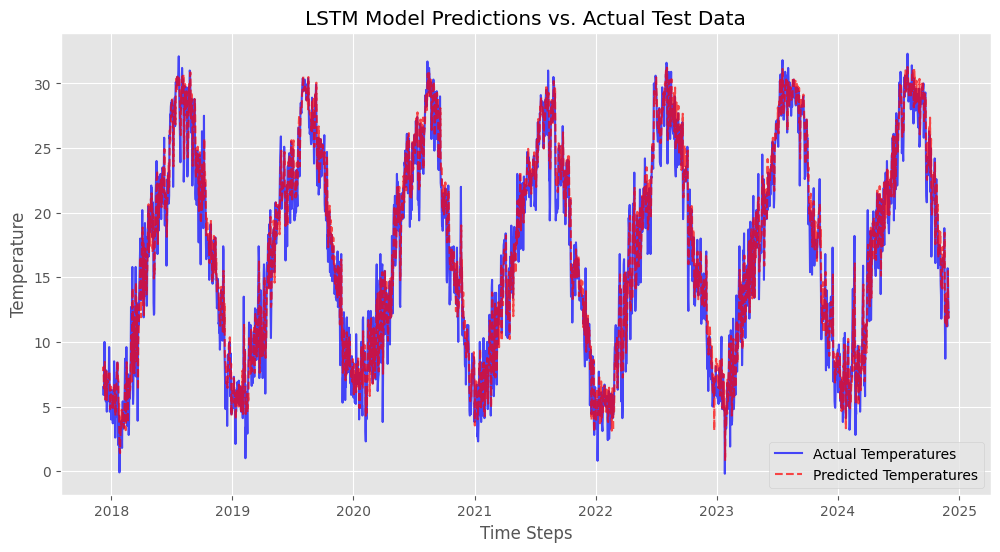

In [ ]:
# Switch to evaluation mode for predictions
model.eval()

# Initialize containers for predictions and actual values
test_predictions = []
actual_values = []
dates = df_temp['date'][train_size:]

# Generate predictions on the test set
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        # Predict
        y_pred = model(x_batch)

        # Store predictions and actual values
        test_predictions.extend(y_pred.cpu().numpy())
        actual_values.extend(y_batch.cpu().numpy())

# Convert lists to numpy arrays
test_predictions = np.array(test_predictions).flatten()
actual_values = np.array(actual_values).flatten()

# Denormalize the predictions and actual values if they were scaled
test_predictions_denormalized = target_scaler.inverse_transform(test_predictions.reshape(-1, 1)).flatten()
actual_values_denormalized = target_scaler.inverse_transform(actual_values.reshape(-1, 1)).flatten()

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(dates, actual_values_denormalized, label="Actual Temperatures", color="blue", alpha=0.7)
plt.plot(dates, test_predictions_denormalized, label="Predicted Temperatures", color="red", linestyle="--", alpha=0.7)
plt.xlabel("Time Steps")
plt.ylabel("Temperature")
plt.title("LSTM Model Predictions vs. Actual Test Data")
plt.legend()
plt.show()

In [ ]:
# Create DataFrame for errors
LTSM_error = pd.DataFrame(test_target[seq_length:], columns=['targets'])
LTSM_error['predictions'] = test_predictions
LTSM_error['error'] = LTSM_error['targets'] - LTSM_error['predictions']
LTSM_error['error_square'] = LTSM_error['error'] ** 2

# Calculate Mean Squared Error (MSE)
err = LTSM_error['error_square'].mean()
print(f'Mean squared error is: {err:.3f}')

Mean squared error is: 0.003


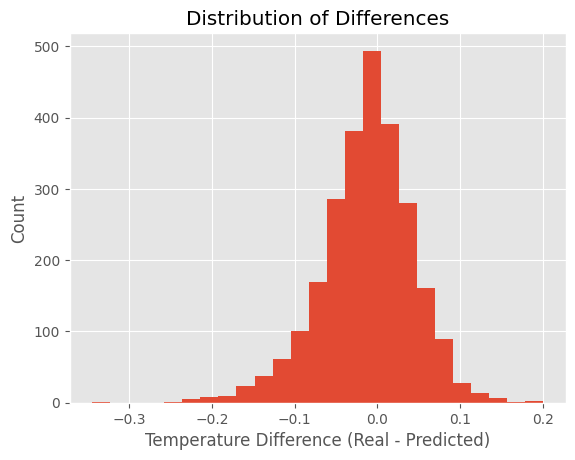

In [ ]:
# Plot the distribution of errors
plt.hist(LTSM_error['error'], bins=25)
plt.xlabel('Temperature Difference (Real - Predicted)')
plt.ylabel('Count')
plt.title('Distribution of Differences')
plt.show()

In [ ]:
def predict_future_temperature(model, input_sequence, scaler, future_steps, device):
    """
    Predict future temperature using a trained LSTM model.

    Args:
        model (torch.nn.Module): Trained LSTM model.
        input_sequence (numpy.ndarray): The last sequence from the dataset to start predictions.
        scaler (MinMaxScaler): Scaler used to normalize the data.
        future_steps (int): Number of future steps to predict.
        device (torch.device): The device to run the model on (GPU or CPU).

    Returns:
        list: Predicted future temperatures (denormalized).
    """
    model.eval()
    predictions = []
    input_sequence = input_sequence.copy()

    # Convert input_sequence to a PyTorch tensor and add batch dimension
    input_tensor = torch.tensor(input_sequence, dtype=torch.float32).unsqueeze(0).to(device)

    with torch.no_grad():
        for _ in range(future_steps):
            # Predict the next temperature
            next_temp = model(input_tensor).item()
            predictions.append(next_temp)

            # Update input sequence by appending the prediction and removing the oldest value
            next_temp_scaled = np.array([[next_temp]])  # Reshape to 2D for scaling

            # Get the number of features (e.g., 8) from the input sequence
            num_features = input_tensor.shape[2]

            # If there's a mismatch in the number of features, pad the prediction with zeros
            if next_temp_scaled.shape[1] < num_features:
                next_temp_scaled = np.concatenate([next_temp_scaled, np.zeros((1, num_features - 1))], axis=1)

            new_input = input_tensor.cpu().numpy()

            # Append the prediction to the input sequence and remove the oldest value
            new_input = np.concatenate([new_input[:, 1:, :], next_temp_scaled.reshape(1, 1, num_features)], axis=1)
            input_tensor = torch.tensor(new_input, dtype=torch.float32).to(device)

    # Denormalize predictions
    predictions_denormalized = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
    return predictions_denormalized.flatten()

# Assuming you have already trained your model

# The last sequence from the dataset (normalized)
last_sequence = test_input[-seq_length:]  # Taking the last sequence from the test set

# Number of future steps to predict
future_steps = seq_length

# Predict future temperatures
model.to(device)
future_temperatures = predict_future_temperature(model, last_sequence, target_scaler, future_steps, device)

# Output the results
#print("Predicted Future Temperatures:", future_temperatures)


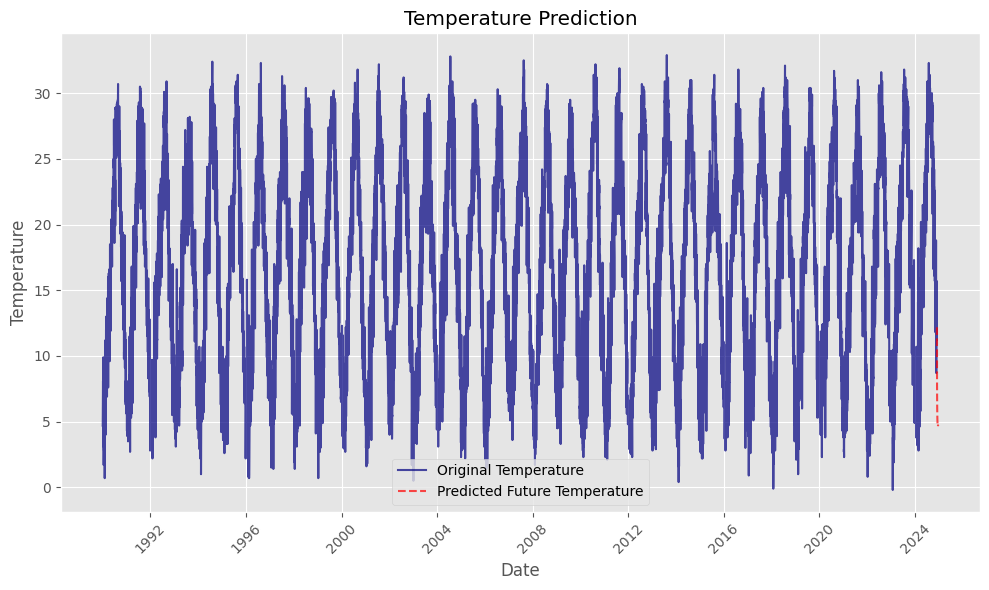

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Predict future temperatures (this assumes your last_sequence is prepared and scaled correctly)
future_temperatures = predict_future_temperature(model, last_sequence, target_scaler, future_steps, device)

# Generate the future dates (this assumes the last date in the original data is the last date for prediction)
last_date = df_temp['date'].iloc[-1]
date_range = pd.date_range(last_date, periods=future_steps + 1, freq='D')[1:]  # Generate dates for future steps

# Denormalize the original temperature data for plotting
original_temperatures = target_scaler.inverse_transform(scaled_target).flatten()

# Plot the original temperature and the predicted future temperatures
plt.figure(figsize=(10, 6))
plt.plot(df_temp['date'], original_temperatures, label='Original Temperature', color='navy', alpha=0.7)
plt.plot(date_range, future_temperatures, label='Predicted Future Temperature', color='red', linestyle='--', alpha=0.7)

# Customize the plot
plt.title('Temperature Prediction')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()
